In [22]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('ab_browser_test.csv')

In [3]:
data.shape

(566134, 6)

In [4]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Описание данных:

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

# 1
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после запятой.

In [7]:
100.0*sum(data.n_clicks[data.slot == 'exp'])/sum(data.n_clicks[data.slot == 'control']) - 100.0

1.6135689824415778

# 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
exp_clicks = data.n_clicks[data.slot == 'exp'].values
control_clicks = data.n_clicks[data.slot == 'control'].values

In [11]:
np.random.seed(0)

exp_clicks_median_scores = map(np.median, get_bootstrap_samples(exp_clicks, 1000))
control_clicks_median_scores = map(np.median, get_bootstrap_samples(control_clicks, 1000))

print "95% confidence interval for the exp median:",  stat_intervals(exp_clicks_median_scores, 0.05)
print "95% confidence interval for the control median:",  stat_intervals(control_clicks_median_scores, 0.05)

95% confidence interval for the exp median: [ 5.  5.]
95% confidence interval for the control median: [ 4.  4.]


In [13]:
print "delta median", np.median(exp_clicks) - np.median(control_clicks)

delta median 1.0


In [14]:
median_scores = zip(map(np.median, exp_clicks_median_scores), map(np.median, control_clicks_median_scores))

In [15]:
delta_median_scores = map(lambda x: x[1] - x[0], median_scores)

In [16]:
print "95% confidence interval for the difference between medians:",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians: [-1. -1.]


In [12]:
np.random.seed(0)

exp_clicks_mean_scores = map(np.mean, get_bootstrap_samples(exp_clicks, 1000))
control_clicks_mean_scores = map(np.mean, get_bootstrap_samples(control_clicks, 1000))

print "95% confidence interval for the exp median:",  stat_intervals(exp_clicks_mean_scores, 0.05)
print "95% confidence interval for the control median:",  stat_intervals(control_clicks_mean_scores, 0.05)

95% confidence interval for the exp median: [ 11.5086867   11.66089388]
95% confidence interval for the control median: [ 11.20795095  11.35742732]


In [13]:
print "delta mean", np.mean(exp_clicks) - np.mean(control_clicks)

delta median 1.0


In [17]:
mean_scores = zip(map(np.mean, exp_clicks_mean_scores), map(np.mean, control_clicks_mean_scores))

In [18]:
delta_mean_scores = map(lambda x: x[1] - x[0], mean_scores)

In [19]:
print "95% confidence interval for the difference between medians:",  stat_intervals(delta_mean_scores, 0.05)

95% confidence interval for the difference between medians: [-0.40475697 -0.19172563]


# 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

# 4
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид X¯−μS2/n√, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

X¯ — среднее значение в выборке — было распределено нормально N(μ,σ2n)
nσ2S2 — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)
Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

Получите из данных n_boot_samples псевдовыборок.
По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды


1
2
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)
Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:



1
2
np.random.seed(0)
n_boot_samples = 500
В качестве ответа отметьте верные утвердения о значениях R2, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.



Почему мы проверяем именно такие условия?

В исходной постановке t-критерий требует нормальности распределения Xi. Именно из-за этого предположения мы имеем, что ∑iXi∼N(nμ,nσ2) в силу линейности матожидания, независимости всех Xi между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что 1n∑iXi−μ ∼ N(0,σ2n)

Заметим теперь, что следующие распределения эквивалентны N(0,σ2n)∼σ2n−−√N(0,1)
То есть другими словами мы получили, что исходная статистика X¯−μS2/n√ распределена как N(0,1)S2nnσ2√ ∼ N(0,1)S2σ2√
Вспомним, что распределение Стьюдента с n−1 степенями свободы определяется как N(0,1)χ2/(n−1)√. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно Xi были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

In [27]:
np.random.seed(0)
n_boot_samples = 500

In [28]:
control_clicks_mean_scores = map(np.mean, get_bootstrap_samples(control_clicks, n_boot_samples))
control_boot_chi_squared = map(lambda x: np.std(x) ** 2, get_bootstrap_samples(control_clicks, n_boot_samples))

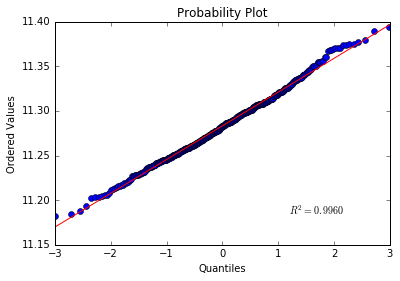

In [29]:
stats.probplot(control_clicks_mean_scores, dist="norm", plot=pylab)
pylab.show()

In [31]:
n = len(control_clicks)

((array([ 282301.08823053,  282512.70968154,  282631.75042722,
          282716.17888972,  282782.34505977,  282837.12445289,
          282884.08540285,  282925.32718791,  282962.19330371,
          282995.59740263,  283026.19007281,  283054.45161347,
          283080.74708393,  283105.36069052,  283128.51819019,
          283150.40200687,  283171.16173795,  283190.92164624,
          283209.78611976,  283227.84373082,  283245.17030322,
          283261.83126851,  283277.88349787,  283293.37674668,
          283308.35480452,  283322.85642116,  283336.91605836,
          283350.56450624,  283363.82939198,  283376.73560272,
          283389.3056399 ,  283401.55991797,  283413.51701748,
          283425.19389996,  283436.60609345,  283447.76785091,
          283458.69228762,  283469.39150063,  283479.87667217,
          283490.15816137,  283500.24558337,  283510.14788029,
          283519.87338263,  283529.42986521,  283538.82459548,
          283548.06437784,  283557.155592  ,  283566.10

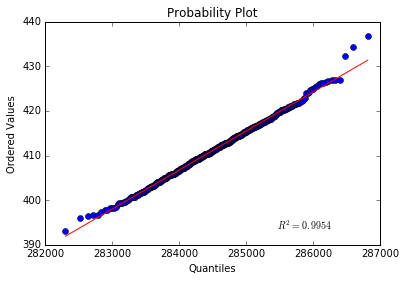

In [32]:
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)

# 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [83]:
exp_mean_user_clicks = data[data.slot == 'exp'].groupby('userID').aggregate(np.sum).n_clicks.tolist()

In [84]:
control_mean_user_clicks = data[data.slot == 'control'].groupby('userID').aggregate(np.sum).n_clicks.tolist()

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [85]:
stats.mannwhitneyu(exp_mean_user_clicks, control_mean_user_clicks)

MannwhitneyuResult(statistic=41140868471.0, pvalue=3.1266857702625713e-74)

# 6
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [62]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [86]:
p_values = []
for curr_browser in data.browser.value_counts().keys():
    p_values.append(scipy.stats.mannwhitneyu(
            data[(data.browser == curr_browser) & (data.slot == 'exp')].n_clicks.values,
            data[(data.browser == curr_browser) & (data.slot == 'control')].n_clicks.values,
            alternative='two-sided')[1])

In [87]:
sum(map(lambda x: x < 0.05, p_values))

1

In [90]:
p_values

[0.81556888807591688,
 0.51616652908421157,
 0.055799789937236381,
 0.0,
 0.90754133162630202,
 0.075379905635521299]

In [88]:
reject, p_corrected, a1, a2 = multipletests(p_values, 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [91]:
p_corrected

array([ 1.        ,  1.        ,  0.27899895,  0.        ,  1.        ,
        0.30151962])

In [89]:
sum(reject)

1

# 7
Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [76]:
browser_clicks_exp = {}
for curr_browser in data.browser.value_counts().keys():
    browser_clicks_exp[curr_browser] = \
        float(sum(data[(data.browser == curr_browser) & (data.slot == 'exp')].n_nonclk_queries.values))\
            /sum(data[(data.browser == curr_browser) & (data.slot == 'exp')].n_queries.values)

In [77]:
for curr_browser, clicks in browser_clicks_exp.iteritems():
    print curr_browser, clicks*100.0

Browser #2 44.9827469486
Browser #4 45.1429419036
Browser #22 39.8539472197
Browser #20 38.9773764837
Browser #17 36.9374128487
Browser #14 43.7556173613


In [78]:
browser_clicks_control = {}
for curr_browser in data.browser.value_counts().keys():
    browser_clicks_control[curr_browser] = \
        float(sum(data[(data.browser == curr_browser) & (data.slot == 'control')].n_nonclk_queries.values))\
            /sum(data[(data.browser == curr_browser) & (data.slot == 'control')].n_queries.values)

In [79]:
for curr_browser, clicks in browser_clicks_control.iteritems():
    print curr_browser, clicks*100.0

Browser #2 45.9627471792
Browser #4 46.9709296351
Browser #22 40.5939765935
Browser #20 40.5404847434
Browser #17 36.2993667463
Browser #14 57.5904113601
